# Plot DAR by subclass

In [1]:
import pandas as pd
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import logomaker
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

In [2]:
import scanpy as sc
import decoupler as dc

In [3]:
os.chdir("/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/")
source_dir = Path("scenicplus/other_celltypes/")
dar_dir = Path("regional_dar_deg/dar")
homer_dir = Path("regional_dar_deg/dar_homer")

In [4]:
homer_database = "/tscc/projects/ps-epigen/users/biy022/MGH/data/metadata/homer2_motif_database.csv"
homer_db = pd.read_csv(homer_database, sep=",", header=0)
homer_db.drop_duplicates("motif_names", inplace=True)
homer_db.dropna(subset=["tfs"], inplace=True)

In [5]:
figure_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/final_figures/")

In [6]:
scGLUE_links_file = "Jinghui_data/output_union_links.xls"
scGLUE_links_df = pd.read_csv(scGLUE_links_file, sep="\t", header=None)
scGLUE_links_df.columns = ["Gene", "Gchr", "Gstart", "Gend", "Rchr", "Rstart", "Rend", "classes", "ncls"]
scGLUE_links_df["Rend"] = scGLUE_links_df["Rend"] + 1
scGLUE_links_df["Region"] = scGLUE_links_df[["Rchr", "Rstart", "Rend"]].astype(str).agg("-".join, axis=1)

In [7]:
subclass = "L4_IT"
rna_counts = sc.read_h5ad(source_dir / "{}_rna_matrix.h5ad".format(subclass))
if rna_counts.raw != None:
    rna_counts = rna_counts.raw.to_adata().copy()
rna_counts_aggr = dc.get_pseudobulk(
    rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=False
)
sc.pp.normalize_total(rna_counts_aggr, target_sum=1e6)
sc.pp.log1p(rna_counts_aggr, base=2)

In [8]:
subclass = "L4_IT"
atac_counts = sc.read_h5ad(source_dir / "{}_atac_matrix.h5ad".format(subclass))
if atac_counts.raw != None:
    atac_counts = atac_counts.raw.to_adata().copy()
atac_counts_aggr = dc.get_pseudobulk(
    atac_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=False
)
sc.pp.normalize_total(atac_counts_aggr, target_sum=1e6)
sc.pp.log1p(atac_counts_aggr, base=2)

In [9]:
regional_dars = dict()
regional_dar_targets = dict()
region_order = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
for region in region_order:
    dar_table = pd.read_csv(dar_dir / subclass / "{}_result.tsv".format(region), sep="\t", header=0, index_col=0)
    dar_sig_list = dar_table[(dar_table["logFC"] > 0) & (dar_table["FDR"] < 0.01)].index.to_list()
    regional_dars[region] = dar_sig_list
    tmpdf = scGLUE_links_df[scGLUE_links_df["Region"].isin(dar_sig_list)].copy()
    tmpdf["expr"] = 0.0
    existed_genes_index = tmpdf["Gene"].isin(rna_counts_aggr.var.index.to_list())
    existed_genes = tmpdf[existed_genes_index]["Gene"].to_list()
    tmpdf.loc[existed_genes_index, "expr"] = rna_counts_aggr[region, existed_genes].X.flatten().tolist()
    selected_genes_index = tmpdf.groupby("Region")["expr"].idxmax()
    selected_genes = tmpdf.loc[selected_genes_index, "Gene"]
    regional_dar_targets[region] = tmpdf["Gene"].to_list()
dar_list = [xx for region in region_order for xx in regional_dars[region]]
dar_target_list = [xx for region in region_order for xx in regional_dar_targets[region]]
right_ys_dict = {k: len(v) for k, v in regional_dars.items() if len(v) > 0}
left_ys_dict = {k: 0 for k in right_ys_dict.keys()}
homer_dict = dict()
for region_homer_dir in (homer_dir / subclass / "results").iterdir():
    region_name = region_homer_dir.name
    region_df = pd.read_csv(region_homer_dir / "knownResults.txt", sep="\t", header=0)
    region_df.reset_index(inplace=True, names=["idx"])
    region_df_sig = region_df[region_df["q-value (Benjamini)"] < 0.01].copy()
    region_df_sig.drop_duplicates("Motif Name", inplace=True)
    region_df_sig = pd.merge(region_df_sig, homer_db, left_on="Motif Name", right_on="motif_names", how="inner")
    homer_dict[region_name] = region_df_sig.head(6)
homer_motif_names = list()
homer_motif_pwms = list()
for k in right_ys_dict.keys():
    if k not in homer_dict:
        continue
    v = homer_dict[k]
    left_ys_dict[k] = len(v)
    for i, r in v.iterrows():
        index = r["idx"] + 1
        curr_pwm_df = pd.read_csv(
            homer_dir / subclass / "results" / k / "knownResults" / f"known{index}.motif",
            skiprows=1, header=None, sep="\t"
        )
        curr_pwm_df.columns = ["A", "C", "G", "T"]
        homer_motif_names.append(r["tfs"])
        homer_motif_pwms.append(curr_pwm_df)
right_ys_coords = np.cumsum([v for k, v in right_ys_dict.items()][:-1])
left_ys_coords = np.cumsum([v for k, v in left_ys_dict.items()][:-1])

In [10]:
dar_target_list = [xx for xx in dar_target_list if xx in rna_counts_aggr.var.index.to_list()]

/tmp/ipykernel_906653/1625507296.py:54: RuntimeWarning: invalid value encountered in divide
  plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std


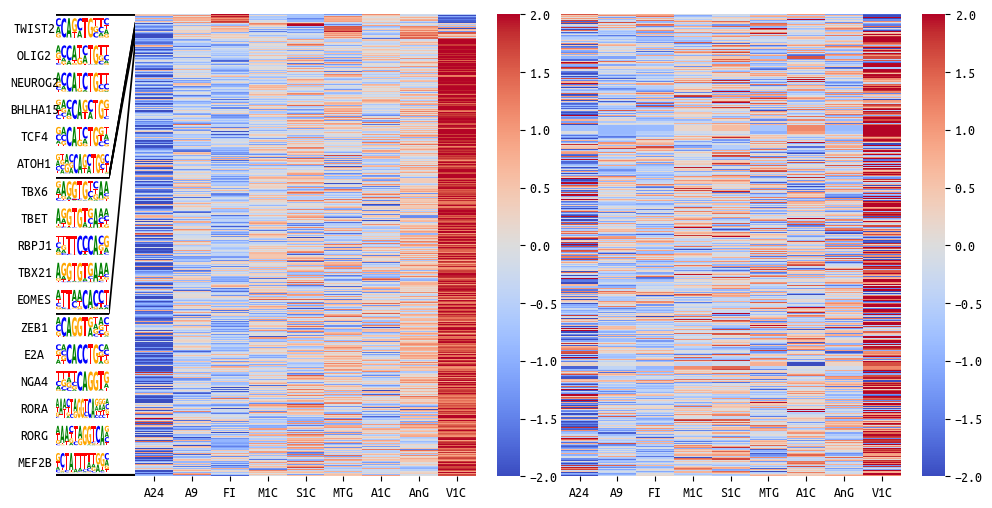

In [11]:
plt.rcParams["font.family"] = "Ubuntu Mono"
fig = plt.figure(figsize=(12, 6))
nrs = len(homer_motif_names)

gs = GridSpec(nrows=1, ncols=4, width_ratios=[1, 0.5, 8, 8])
left_column = gs[0]
left_gs = GridSpecFromSubplotSpec(nrows=nrs, ncols=1, subplot_spec=left_column)
right_column = gs[2]

group_index = [0] + left_ys_coords.tolist()
for i in range(nrs):
    curr_ax = fig.add_subplot(left_gs[i, 0])
    logomaker.Logo(homer_motif_pwms[i], ax=curr_ax, baseline_width=0.0)
    curr_ax.set_ylim(-0.2, 1.2)
    curr_ax.set_axis_off()
    curr_ax.text(-0.4, 0.5, homer_motif_names[i], va="center", ha="center", transform=curr_ax.transAxes)
    curr_bbox = curr_ax.get_position()
    if i in group_index:
        curr_ax.plot(
            [*curr_ax.get_xlim()], 
            [1.2, 1.2], 
            color="black", 
            lw=2, 
            ls="-"
        )
    if i == nrs - 1:
        curr_ax.plot(
            [*curr_ax.get_xlim()], 
            [-0.2, -0.2], 
            color="black", 
            lw=3, 
            ls="-"
        )

plot_mat = atac_counts_aggr[region_order, dar_list].X.T
plot_mat_mean = np.mean(plot_mat, axis=1, keepdims=True)
plot_mat_std = np.std(plot_mat, axis=1, keepdims=True)
plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std
right_ax = fig.add_subplot(right_column)
sns.heatmap(
    plot_mat_z,
    cmap="coolwarm",
    vmin=-2,
    vmax=2,
    ax=right_ax,
    yticklabels=[],
    xticklabels=region_order,
    rasterized=True
)

plot_mat = rna_counts_aggr[region_order, dar_target_list].X.T
plot_mat_mean = np.mean(plot_mat, axis=1, keepdims=True)
plot_mat_std = np.std(plot_mat, axis=1, keepdims=True)
plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std
rna_ax = fig.add_subplot(gs[3])
sns.heatmap(
    plot_mat_z,
    cmap="coolwarm",
    vmin=-2,
    vmax=2,
    ax=rna_ax,
    yticklabels=[],
    xticklabels=region_order,
    rasterized=True
)

middle_column = gs[1]
middle_ax = fig.add_subplot(middle_column, sharey=right_ax)
group_start = [v+1 for v in right_ys_coords]
# middle_ax.set_aspect("equal")
middle_ax.plot([0, 1], [0, 0], lw=2, color="black", ls="-")
middle_ax.plot([0, 1], [len(dar_list), len(dar_list)], lw=3, color="black", ls="-")
hspace = len(dar_list) / nrs
for i, s in enumerate(group_start):
    middle_ax.plot([0, 1], [hspace * group_index[i+1], s], lw=1.25, color="black", ls="-")
middle_ax.set_xlim(0, 1)
middle_ax.set_axis_off()

fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.savefig(figure_dir / "{}-dar-heatmap.pdf".format(subclass), format="pdf")

In [7]:
subclass = "L2_3_IT"
rna_counts = sc.read_h5ad(source_dir / "{}_rna_matrix.h5ad".format(subclass))
if rna_counts.raw != None:
    rna_counts = rna_counts.raw.to_adata().copy()
rna_counts_aggr = dc.get_pseudobulk(
    rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=False
)
sc.pp.normalize_total(rna_counts_aggr, target_sum=1e6)
sc.pp.log1p(rna_counts_aggr, base=2)

In [8]:
subclass = "L2_3_IT"
atac_counts = sc.read_h5ad(source_dir / "{}_atac_matrix.h5ad".format(subclass))
if atac_counts.raw != None:
    atac_counts = atac_counts.raw.to_adata().copy()
atac_counts_aggr = dc.get_pseudobulk(
    atac_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=False
)
sc.pp.normalize_total(atac_counts_aggr, target_sum=1e6)
sc.pp.log1p(atac_counts_aggr, base=2)

In [9]:
regional_dars = dict()
regional_dar_targets = dict()
region_order = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
for region in region_order:
    dar_table = pd.read_csv(dar_dir / subclass / "{}_result.tsv".format(region), sep="\t", header=0, index_col=0)
    dar_sig_list = dar_table[(dar_table["logFC"] > 0) & (dar_table["FDR"] < 0.01)].index.to_list()
    regional_dars[region] = dar_sig_list
    tmpdf = scGLUE_links_df[scGLUE_links_df["Region"].isin(dar_sig_list)].copy()
    tmpdf["expr"] = 0.0
    existed_genes_index = tmpdf["Gene"].isin(rna_counts_aggr.var.index.to_list())
    existed_genes = tmpdf[existed_genes_index]["Gene"].to_list()
    tmpdf.loc[existed_genes_index, "expr"] = rna_counts_aggr[region, existed_genes].X.flatten().tolist()
    selected_genes_index = tmpdf.groupby("Region")["expr"].idxmax()
    selected_genes = tmpdf.loc[selected_genes_index, "Gene"]
    regional_dar_targets[region] = tmpdf["Gene"].to_list()
dar_list = [xx for region in region_order for xx in regional_dars[region]]
dar_target_list = [xx for region in region_order for xx in regional_dar_targets[region]]
right_ys_dict = {k: len(v) for k, v in regional_dars.items() if len(v) > 0}
left_ys_dict = {k: 0 for k in right_ys_dict.keys()}
homer_dict = dict()
for region_homer_dir in (homer_dir / subclass / "results").iterdir():
    region_name = region_homer_dir.name
    region_df = pd.read_csv(region_homer_dir / "knownResults.txt", sep="\t", header=0)
    region_df.reset_index(inplace=True, names=["idx"])
    region_df_sig = region_df[region_df["q-value (Benjamini)"] < 0.01].copy()
    region_df_sig.drop_duplicates("Motif Name", inplace=True)
    region_df_sig = pd.merge(region_df_sig, homer_db, left_on="Motif Name", right_on="motif_names", how="inner")
    homer_dict[region_name] = region_df_sig.head(6)
homer_motif_names = list()
homer_motif_pwms = list()
for k in right_ys_dict.keys():
    if k not in homer_dict:
        continue
    v = homer_dict[k]
    left_ys_dict[k] = len(v)
    for i, r in v.iterrows():
        index = r["idx"] + 1
        curr_pwm_df = pd.read_csv(
            homer_dir / subclass / "results" / k / "knownResults" / f"known{index}.motif",
            skiprows=1, header=None, sep="\t"
        )
        curr_pwm_df.columns = ["A", "C", "G", "T"]
        homer_motif_names.append(r["tfs"])
        homer_motif_pwms.append(curr_pwm_df)
right_ys_coords = np.cumsum([v for k, v in right_ys_dict.items()][:-1])
left_ys_coords = np.cumsum([v for k, v in left_ys_dict.items()][:-1])

In [10]:
dar_target_list = [xx for xx in dar_target_list if xx in rna_counts_aggr.var.index.to_list()]

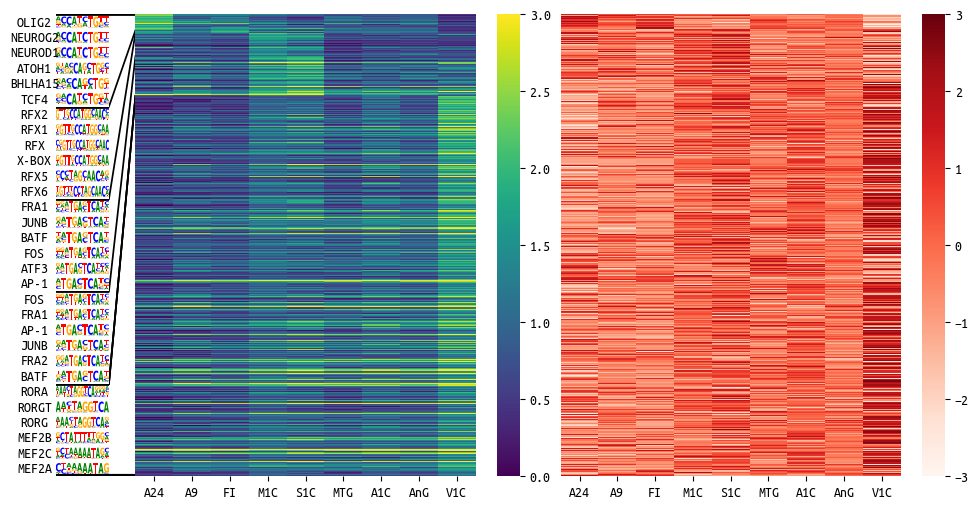

In [13]:
plt.rcParams["font.family"] = "Ubuntu Mono"
fig = plt.figure(figsize=(12, 6))
nrs = len(homer_motif_names)

gs = GridSpec(nrows=1, ncols=4, width_ratios=[1, 0.5, 8, 8])
left_column = gs[0]
left_gs = GridSpecFromSubplotSpec(nrows=nrs, ncols=1, subplot_spec=left_column)
right_column = gs[2]

group_index = [0] + left_ys_coords.tolist()
for i in range(nrs):
    curr_ax = fig.add_subplot(left_gs[i, 0])
    logomaker.Logo(homer_motif_pwms[i], ax=curr_ax, baseline_width=0.0)
    curr_ax.set_ylim(-0.2, 1.2)
    curr_ax.set_axis_off()
    curr_ax.text(-0.4, 0.5, homer_motif_names[i], va="center", ha="center", transform=curr_ax.transAxes)
    curr_bbox = curr_ax.get_position()
    if i in group_index:
        curr_ax.plot(
            [*curr_ax.get_xlim()], 
            [1.2, 1.2], 
            color="black", 
            lw=2, 
            ls="-"
        )
    if i == nrs - 1:
        curr_ax.plot(
            [*curr_ax.get_xlim()], 
            [-0.2, -0.2], 
            color="black", 
            lw=3, 
            ls="-"
        )

plot_mat = atac_counts_aggr[region_order, dar_list].X.T
plot_mat_mean = np.mean(plot_mat, axis=1, keepdims=True)
plot_mat_std = np.std(plot_mat, axis=1, keepdims=True)
plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std
right_ax = fig.add_subplot(right_column)
sns.heatmap(
    plot_mat,
    cmap="viridis",
    vmin=0,
    vmax=3,
    ax=right_ax,
    yticklabels=[],
    xticklabels=region_order,
)

plot_mat = rna_counts_aggr[region_order, dar_target_list].X.T
plot_mat_mean = np.mean(plot_mat, axis=1, keepdims=True)
plot_mat_std = np.std(plot_mat, axis=1, keepdims=True)
plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std
rna_ax = fig.add_subplot(gs[3])
sns.heatmap(
    plot_mat_z,
    cmap="Reds",
    vmin=-3,
    vmax=3,
    ax=rna_ax,
    yticklabels=[],
    xticklabels=region_order,
)

middle_column = gs[1]
middle_ax = fig.add_subplot(middle_column, sharey=right_ax)
group_start = [v+1 for v in right_ys_coords]
# middle_ax.set_aspect("equal")
middle_ax.plot([0, 1], [0, 0], lw=2, color="black", ls="-")
middle_ax.plot([0, 1], [len(dar_list), len(dar_list)], lw=3, color="black", ls="-")
hspace = len(dar_list) / nrs
for i, s in enumerate(group_start):
    middle_ax.plot([0, 1], [hspace * group_index[i+1], s], lw=1.25, color="black", ls="-")
middle_ax.set_xlim(0, 1)
middle_ax.set_axis_off()

fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.savefig(figure_dir / "{}-dar-heatmap.pdf".format(subclass), format="pdf")

In [12]:
subclass = "L5_IT"
rna_counts = sc.read_h5ad(source_dir / "{}_rna_matrix.h5ad".format(subclass))
if rna_counts.raw != None:
    rna_counts = rna_counts.raw.to_adata().copy()
rna_counts_aggr = dc.get_pseudobulk(
    rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=False
)
sc.pp.normalize_total(rna_counts_aggr, target_sum=1e6)
sc.pp.log1p(rna_counts_aggr, base=2)

In [13]:
subclass = "L5_IT"
atac_counts = sc.read_h5ad(source_dir / "{}_atac_matrix.h5ad".format(subclass))
if atac_counts.raw != None:
    atac_counts = atac_counts.raw.to_adata().copy()
atac_counts_aggr = dc.get_pseudobulk(
    atac_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=False
)
sc.pp.normalize_total(atac_counts_aggr, target_sum=1e6)
sc.pp.log1p(atac_counts_aggr, base=2)

In [14]:
regional_dars = dict()
regional_dar_targets = dict()
region_order = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
for region in region_order:
    dar_table = pd.read_csv(dar_dir / subclass / "{}_result.tsv".format(region), sep="\t", header=0, index_col=0)
    dar_sig_list = dar_table[(dar_table["logFC"] > 0) & (dar_table["FDR"] < 0.01)].index.to_list()
    regional_dars[region] = dar_sig_list
    regional_dar_targets[region] = scGLUE_links_df[scGLUE_links_df["Region"].isin(dar_sig_list)]["Gene"].unique()
dar_list = [xx for region in region_order for xx in regional_dars[region]]
dar_target_list = [xx for region in region_order for xx in regional_dar_targets[region]]
right_ys_dict = {k: len(v) for k, v in regional_dars.items() if len(v) > 0}
left_ys_dict = {k: 0 for k in right_ys_dict.keys()}
homer_dict = dict()
for region_homer_dir in (homer_dir / subclass / "results").iterdir():
    region_name = region_homer_dir.name
    region_df = pd.read_csv(region_homer_dir / "knownResults.txt", sep="\t", header=0)
    region_df.reset_index(inplace=True, names=["idx"])
    region_df_sig = region_df[region_df["q-value (Benjamini)"] < 0.01].copy()
    region_df_sig.drop_duplicates("Motif Name", inplace=True)
    region_df_sig = pd.merge(region_df_sig, homer_db, left_on="Motif Name", right_on="motif_names", how="inner")
    homer_dict[region_name] = region_df_sig.head(6)
homer_motif_names = list()
homer_motif_pwms = list()
for k in right_ys_dict.keys():
    if k not in homer_dict:
        continue
    v = homer_dict[k]
    left_ys_dict[k] = len(v)
    for i, r in v.iterrows():
        index = r["idx"] + 1
        curr_pwm_df = pd.read_csv(
            homer_dir / subclass / "results" / k / "knownResults" / f"known{index}.motif",
            skiprows=1, header=None, sep="\t"
        )
        curr_pwm_df.columns = ["A", "C", "G", "T"]
        homer_motif_names.append(r["tfs"])
        homer_motif_pwms.append(curr_pwm_df)
right_ys_coords = np.cumsum([v for k, v in right_ys_dict.items()][:-1])
left_ys_coords = np.cumsum([v for k, v in left_ys_dict.items()][:-1])

In [15]:
dar_target_list = [xx for xx in dar_target_list if xx in rna_counts_aggr.var.index.to_list()]

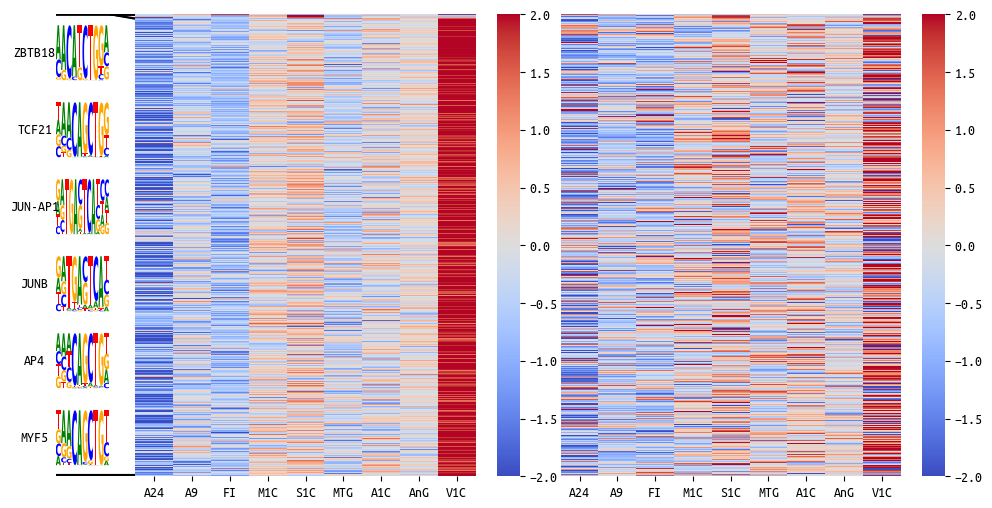

In [16]:
plt.rcParams["font.family"] = "Ubuntu Mono"
fig = plt.figure(figsize=(12, 6))
nrs = len(homer_motif_names)

gs = GridSpec(nrows=1, ncols=4, width_ratios=[1, 0.5, 8, 8])
left_column = gs[0]
left_gs = GridSpecFromSubplotSpec(nrows=nrs, ncols=1, subplot_spec=left_column)
right_column = gs[2]

group_index = [0] + left_ys_coords.tolist()
for i in range(nrs):
    curr_ax = fig.add_subplot(left_gs[i, 0])
    logomaker.Logo(homer_motif_pwms[i], ax=curr_ax, baseline_width=0.0)
    curr_ax.set_ylim(-0.2, 1.2)
    curr_ax.set_axis_off()
    curr_ax.text(-0.4, 0.5, homer_motif_names[i], va="center", ha="center", transform=curr_ax.transAxes)
    curr_bbox = curr_ax.get_position()
    if i in group_index:
        curr_ax.plot(
            [*curr_ax.get_xlim()], 
            [1.2, 1.2], 
            color="black", 
            lw=2, 
            ls="-"
        )
    if i == nrs - 1:
        curr_ax.plot(
            [*curr_ax.get_xlim()], 
            [-0.2, -0.2], 
            color="black", 
            lw=3, 
            ls="-"
        )

plot_mat = atac_counts_aggr[region_order, dar_list].X.T
plot_mat_mean = np.mean(plot_mat, axis=1, keepdims=True)
plot_mat_std = np.std(plot_mat, axis=1, keepdims=True)
plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std
right_ax = fig.add_subplot(right_column)
sns.heatmap(
    plot_mat_z,
    cmap="coolwarm",
    vmin=-2,
    vmax=2,
    ax=right_ax,
    yticklabels=[],
    xticklabels=region_order,
)

plot_mat = rna_counts_aggr[region_order, dar_target_list].X.T
plot_mat_mean = np.mean(plot_mat, axis=1, keepdims=True)
plot_mat_std = np.std(plot_mat, axis=1, keepdims=True)
plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std
rna_ax = fig.add_subplot(gs[3])
sns.heatmap(
    plot_mat_z,
    cmap="coolwarm",
    vmin=-2,
    vmax=2,
    ax=rna_ax,
    yticklabels=[],
    xticklabels=region_order,
)

middle_column = gs[1]
middle_ax = fig.add_subplot(middle_column, sharey=right_ax)
group_start = [v+1 for v in right_ys_coords]
# middle_ax.set_aspect("equal")
middle_ax.plot([0, 1], [0, 0], lw=2, color="black", ls="-")
middle_ax.plot([0, 1], [len(dar_list), len(dar_list)], lw=3, color="black", ls="-")
hspace = len(dar_list) / nrs
for i, s in enumerate(group_start):
    middle_ax.plot([0, 1], [hspace * group_index[i+1], s], lw=1.25, color="black", ls="-")
middle_ax.set_xlim(0, 1)
middle_ax.set_axis_off()

fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.savefig(figure_dir / "{}-dar-heatmap.pdf".format(subclass), dpi=300, format="pdf")

In [17]:
subclass = "L6_IT"
rna_counts = sc.read_h5ad(source_dir / "{}_rna_matrix.h5ad".format(subclass))
if rna_counts.raw != None:
    rna_counts = rna_counts.raw.to_adata().copy()
rna_counts_aggr = dc.get_pseudobulk(
    rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=False
)
sc.pp.normalize_total(rna_counts_aggr, target_sum=1e6)
sc.pp.log1p(rna_counts_aggr, base=2)

In [18]:
subclass = "L6_IT"
atac_counts = sc.read_h5ad(source_dir / "{}_atac_matrix.h5ad".format(subclass))
if atac_counts.raw != None:
    atac_counts = atac_counts.raw.to_adata().copy()
atac_counts_aggr = dc.get_pseudobulk(
    atac_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=False
)
sc.pp.normalize_total(atac_counts_aggr, target_sum=1e6)
sc.pp.log1p(atac_counts_aggr, base=2)

In [19]:
regional_dars = dict()
regional_dar_targets = dict()
region_order = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
for region in region_order:
    dar_table = pd.read_csv(dar_dir / subclass / "{}_result.tsv".format(region), sep="\t", header=0, index_col=0)
    dar_sig_list = dar_table[(dar_table["logFC"] > 0) & (dar_table["FDR"] < 0.01)].index.to_list()
    regional_dars[region] = dar_sig_list
    regional_dar_targets[region] = scGLUE_links_df[scGLUE_links_df["Region"].isin(dar_sig_list)]["Gene"].unique()
dar_list = [xx for region in region_order for xx in regional_dars[region]]
dar_target_list = [xx for region in region_order for xx in regional_dar_targets[region]]
right_ys_dict = {k: len(v) for k, v in regional_dars.items() if len(v) > 0}
left_ys_dict = {k: 0 for k in right_ys_dict.keys()}
homer_dict = dict()
for region_homer_dir in (homer_dir / subclass / "results").iterdir():
    region_name = region_homer_dir.name
    region_df = pd.read_csv(region_homer_dir / "knownResults.txt", sep="\t", header=0)
    region_df.reset_index(inplace=True, names=["idx"])
    region_df_sig = region_df[region_df["q-value (Benjamini)"] < 0.01].copy()
    region_df_sig.drop_duplicates("Motif Name", inplace=True)
    region_df_sig = pd.merge(region_df_sig, homer_db, left_on="Motif Name", right_on="motif_names", how="inner")
    homer_dict[region_name] = region_df_sig.head(6)
homer_motif_names = list()
homer_motif_pwms = list()
for k in right_ys_dict.keys():
    if k not in homer_dict:
        continue
    v = homer_dict[k]
    left_ys_dict[k] = len(v)
    for i, r in v.iterrows():
        index = r["idx"] + 1
        curr_pwm_df = pd.read_csv(
            homer_dir / subclass / "results" / k / "knownResults" / f"known{index}.motif",
            skiprows=1, header=None, sep="\t"
        )
        curr_pwm_df.columns = ["A", "C", "G", "T"]
        homer_motif_names.append(r["tfs"])
        homer_motif_pwms.append(curr_pwm_df)
right_ys_coords = np.cumsum([v for k, v in right_ys_dict.items()][:-1])
left_ys_coords = np.cumsum([v for k, v in left_ys_dict.items()][:-1])

In [20]:
dar_target_list = [xx for xx in dar_target_list if xx in rna_counts_aggr.var.index.to_list()]

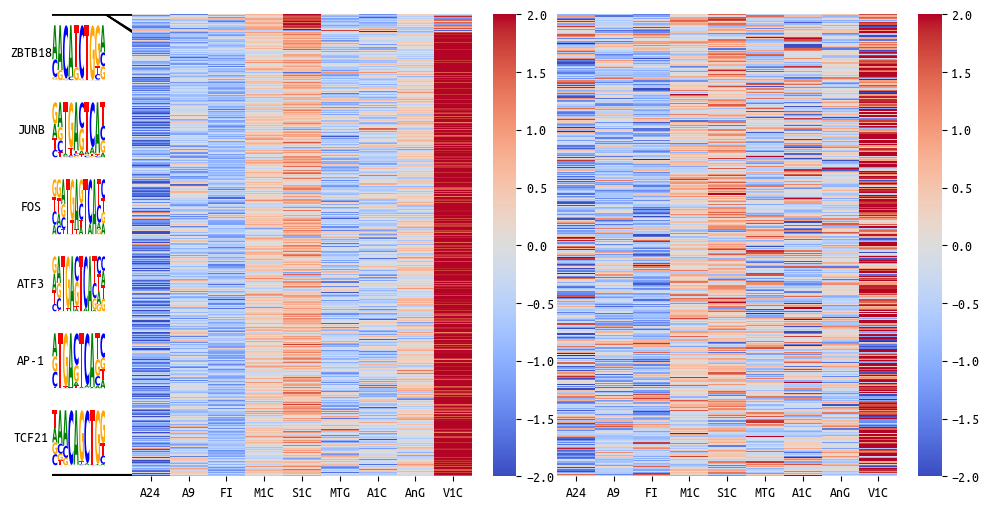

In [21]:
plt.rcParams["font.family"] = "Ubuntu Mono"
fig = plt.figure(figsize=(12, 6))
nrs = len(homer_motif_names)

gs = GridSpec(nrows=1, ncols=4, width_ratios=[1, 0.5, 8, 8])
left_column = gs[0]
left_gs = GridSpecFromSubplotSpec(nrows=nrs, ncols=1, subplot_spec=left_column)
right_column = gs[2]

group_index = [0] + left_ys_coords.tolist()
for i in range(nrs):
    curr_ax = fig.add_subplot(left_gs[i, 0])
    logomaker.Logo(homer_motif_pwms[i], ax=curr_ax, baseline_width=0.0)
    curr_ax.set_ylim(-0.2, 1.2)
    curr_ax.set_axis_off()
    curr_ax.text(-0.4, 0.5, homer_motif_names[i], va="center", ha="center", transform=curr_ax.transAxes)
    curr_bbox = curr_ax.get_position()
    if i in group_index:
        curr_ax.plot(
            [*curr_ax.get_xlim()], 
            [1.2, 1.2], 
            color="black", 
            lw=2, 
            ls="-"
        )
    if i == nrs - 1:
        curr_ax.plot(
            [*curr_ax.get_xlim()], 
            [-0.2, -0.2], 
            color="black", 
            lw=3, 
            ls="-"
        )

plot_mat = atac_counts_aggr[region_order, dar_list].X.T
plot_mat_mean = np.mean(plot_mat, axis=1, keepdims=True)
plot_mat_std = np.std(plot_mat, axis=1, keepdims=True)
plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std
right_ax = fig.add_subplot(right_column)
sns.heatmap(
    plot_mat_z,
    cmap="coolwarm",
    vmin=-2,
    vmax=2,
    ax=right_ax,
    yticklabels=[],
    xticklabels=region_order,
)

plot_mat = rna_counts_aggr[region_order, dar_target_list].X.T
plot_mat_mean = np.mean(plot_mat, axis=1, keepdims=True)
plot_mat_std = np.std(plot_mat, axis=1, keepdims=True)
plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std
rna_ax = fig.add_subplot(gs[3])
sns.heatmap(
    plot_mat_z,
    cmap="coolwarm",
    vmin=-2,
    vmax=2,
    ax=rna_ax,
    yticklabels=[],
    xticklabels=region_order,
)

middle_column = gs[1]
middle_ax = fig.add_subplot(middle_column, sharey=right_ax)
group_start = [v+1 for v in right_ys_coords]
# middle_ax.set_aspect("equal")
middle_ax.plot([0, 1], [0, 0], lw=2, color="black", ls="-")
middle_ax.plot([0, 1], [len(dar_list), len(dar_list)], lw=3, color="black", ls="-")
hspace = len(dar_list) / nrs
for i, s in enumerate(group_start):
    middle_ax.plot([0, 1], [hspace * group_index[i+1], s], lw=1.25, color="black", ls="-")
middle_ax.set_xlim(0, 1)
middle_ax.set_axis_off()

fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.savefig(figure_dir / "{}-dar-heatmap.pdf".format(subclass), dpi=300, format="pdf")

In [7]:
subclass = "Oligo"
rna_counts = sc.read_h5ad(source_dir / "{}_rna_matrix.h5ad".format(subclass))
if rna_counts.raw != None:
    rna_counts = rna_counts.raw.to_adata().copy()
rna_counts_aggr = dc.get_pseudobulk(
    rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=False
)
sc.pp.normalize_total(rna_counts_aggr, target_sum=1e6)
sc.pp.log1p(rna_counts_aggr, base=2)

In [8]:
subclass = "Oligo"
atac_counts = sc.read_h5ad(source_dir / "{}_atac_matrix.h5ad".format(subclass))
if atac_counts.raw != None:
    atac_counts = atac_counts.raw.to_adata().copy()
atac_counts_aggr = dc.get_pseudobulk(
    atac_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=False
)
sc.pp.normalize_total(atac_counts_aggr, target_sum=1e6)
sc.pp.log1p(atac_counts_aggr, base=2)

In [17]:
regional_dars = dict()
regional_dar_targets = dict()
region_order = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
for region in region_order:
    dar_table = pd.read_csv(dar_dir / subclass / "{}_result.tsv".format(region), sep="\t", header=0, index_col=0)
    dar_sig_list = dar_table[(dar_table["logFC"] > 0) & (dar_table["FDR"] < 0.01)].index.to_list()
    regional_dars[region] = dar_sig_list
    regional_dar_targets[region] = scGLUE_links_df[scGLUE_links_df["Region"].isin(dar_sig_list)]["Gene"].unique()
dar_list = [xx for region in region_order for xx in regional_dars[region]]
dar_target_list = [xx for region in region_order for xx in regional_dar_targets[region]]
right_ys_dict = {k: len(v) for k, v in regional_dars.items() if len(v) > 0}
left_ys_dict = {k: 0 for k in right_ys_dict.keys()}
homer_dict = dict()
for region_homer_dir in (homer_dir / subclass / "results").iterdir():
    region_name = region_homer_dir.name
    region_df = pd.read_csv(region_homer_dir / "knownResults.txt", sep="\t", header=0)
    region_df.reset_index(inplace=True, names=["idx"])
    region_df_sig = region_df[region_df["P-value"] < 0.01].copy()
    region_df_sig.drop_duplicates("Motif Name", inplace=True)
    region_df_sig = pd.merge(region_df_sig, homer_db, left_on="Motif Name", right_on="motif_names", how="inner")
    homer_dict[region_name] = region_df_sig.head(6)
homer_motif_names = list()
homer_motif_pwms = list()
for k in right_ys_dict.keys():
    if k not in homer_dict:
        continue
    v = homer_dict[k]
    left_ys_dict[k] = len(v)
    for i, r in v.iterrows():
        index = r["idx"] + 1
        curr_pwm_df = pd.read_csv(
            homer_dir / subclass / "results" / k / "knownResults" / f"known{index}.motif",
            skiprows=1, header=None, sep="\t"
        )
        curr_pwm_df.columns = ["A", "C", "G", "T"]
        homer_motif_names.append(r["tfs"])
        homer_motif_pwms.append(curr_pwm_df)
right_ys_coords = np.cumsum([v for k, v in right_ys_dict.items()][:-1])
left_ys_coords = np.cumsum([v for k, v in left_ys_dict.items()][:-1])

In [18]:
dar_target_list = [xx for xx in dar_target_list if xx in rna_counts_aggr.var.index.to_list()]

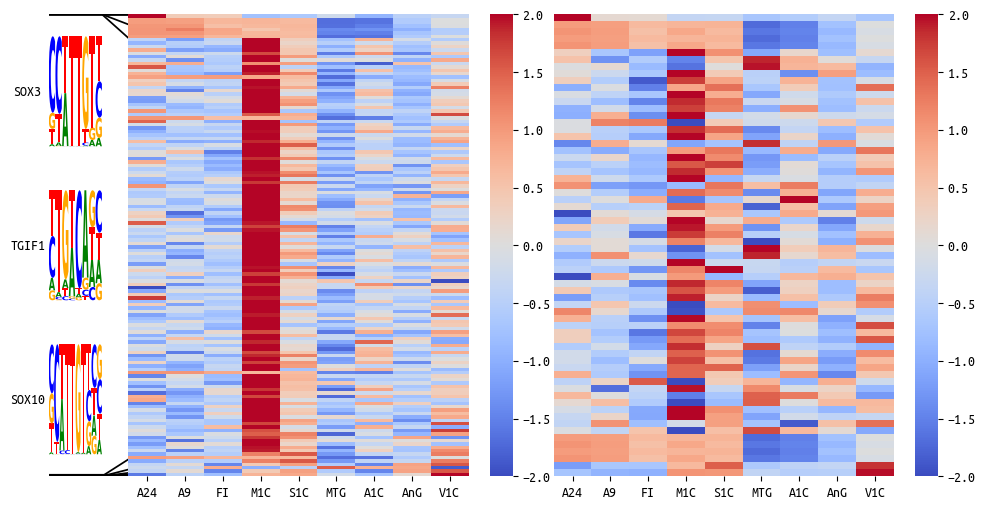

In [19]:
plt.rcParams["font.family"] = "Ubuntu Mono"
fig = plt.figure(figsize=(12, 6))
nrs = len(homer_motif_names)

gs = GridSpec(nrows=1, ncols=4, width_ratios=[1, 0.5, 8, 8])
left_column = gs[0]
left_gs = GridSpecFromSubplotSpec(nrows=nrs, ncols=1, subplot_spec=left_column)
right_column = gs[2]

group_index = [0] + left_ys_coords.tolist()
for i in range(nrs):
    curr_ax = fig.add_subplot(left_gs[i, 0])
    logomaker.Logo(homer_motif_pwms[i], ax=curr_ax, baseline_width=0.0)
    curr_ax.set_ylim(-0.2, 1.2)
    curr_ax.set_axis_off()
    curr_ax.text(-0.4, 0.5, homer_motif_names[i], va="center", ha="center", transform=curr_ax.transAxes)
    curr_bbox = curr_ax.get_position()
    if i in group_index:
        curr_ax.plot(
            [*curr_ax.get_xlim()], 
            [1.2, 1.2], 
            color="black", 
            lw=2, 
            ls="-"
        )
    if i == nrs - 1:
        curr_ax.plot(
            [*curr_ax.get_xlim()], 
            [-0.2, -0.2], 
            color="black", 
            lw=3, 
            ls="-"
        )

plot_mat = atac_counts_aggr[region_order, dar_list].X.T
plot_mat_mean = np.mean(plot_mat, axis=1, keepdims=True)
plot_mat_std = np.std(plot_mat, axis=1, keepdims=True)
plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std
right_ax = fig.add_subplot(right_column)
sns.heatmap(
    plot_mat_z,
    cmap="coolwarm",
    vmin=-2,
    vmax=2,
    ax=right_ax,
    yticklabels=[],
    xticklabels=region_order,
)

plot_mat = rna_counts_aggr[region_order, dar_target_list].X.T
plot_mat_mean = np.mean(plot_mat, axis=1, keepdims=True)
plot_mat_std = np.std(plot_mat, axis=1, keepdims=True)
plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std
rna_ax = fig.add_subplot(gs[3])
sns.heatmap(
    plot_mat_z,
    cmap="coolwarm",
    vmin=-2,
    vmax=2,
    ax=rna_ax,
    yticklabels=[],
    xticklabels=region_order,
)

middle_column = gs[1]
middle_ax = fig.add_subplot(middle_column, sharey=right_ax)
group_start = [v+1 for v in right_ys_coords]
# middle_ax.set_aspect("equal")
middle_ax.plot([0, 1], [0, 0], lw=2, color="black", ls="-")
middle_ax.plot([0, 1], [len(dar_list), len(dar_list)], lw=3, color="black", ls="-")
hspace = len(dar_list) / nrs
for i, s in enumerate(group_start):
    middle_ax.plot([0, 1], [hspace * group_index[i+1], s], lw=1.25, color="black", ls="-")
middle_ax.set_xlim(0, 1)
middle_ax.set_axis_off()

fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.savefig(figure_dir / "{}-dar-heatmap.pdf".format(subclass), dpi=300, format="pdf")

In [20]:
subclass = "Astro"
rna_counts = sc.read_h5ad(source_dir / "{}_rna_matrix.h5ad".format(subclass))
if rna_counts.raw != None:
    rna_counts = rna_counts.raw.to_adata().copy()
rna_counts_aggr = dc.get_pseudobulk(
    rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=False
)
sc.pp.normalize_total(rna_counts_aggr, target_sum=1e6)
sc.pp.log1p(rna_counts_aggr, base=2)

In [21]:
subclass = "Astro"
atac_counts = sc.read_h5ad(source_dir / "{}_atac_matrix.h5ad".format(subclass))
if atac_counts.raw != None:
    atac_counts = atac_counts.raw.to_adata().copy()
atac_counts_aggr = dc.get_pseudobulk(
    atac_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=False
)
sc.pp.normalize_total(atac_counts_aggr, target_sum=1e6)
sc.pp.log1p(atac_counts_aggr, base=2)

In [22]:
regional_dars = dict()
regional_dar_targets = dict()
region_order = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
for region in region_order:
    dar_table = pd.read_csv(dar_dir / subclass / "{}_result.tsv".format(region), sep="\t", header=0, index_col=0)
    dar_sig_list = dar_table[(dar_table["logFC"] > 0) & (dar_table["FDR"] < 0.01)].index.to_list()
    regional_dars[region] = dar_sig_list
    regional_dar_targets[region] = scGLUE_links_df[scGLUE_links_df["Region"].isin(dar_sig_list)]["Gene"].unique()
dar_list = [xx for region in region_order for xx in regional_dars[region]]
dar_target_list = [xx for region in region_order for xx in regional_dar_targets[region]]
right_ys_dict = {k: len(v) for k, v in regional_dars.items() if len(v) > 0}
left_ys_dict = {k: 0 for k in right_ys_dict.keys()}
homer_dict = dict()
for region_homer_dir in (homer_dir / subclass / "results").iterdir():
    region_name = region_homer_dir.name
    region_df = pd.read_csv(region_homer_dir / "knownResults.txt", sep="\t", header=0)
    region_df.reset_index(inplace=True, names=["idx"])
    region_df_sig = region_df[region_df["P-value"] < 0.01].copy()
    region_df_sig.drop_duplicates("Motif Name", inplace=True)
    region_df_sig = pd.merge(region_df_sig, homer_db, left_on="Motif Name", right_on="motif_names", how="inner")
    homer_dict[region_name] = region_df_sig.head(6)
homer_motif_names = list()
homer_motif_pwms = list()
for k in right_ys_dict.keys():
    if k not in homer_dict:
        continue
    v = homer_dict[k]
    left_ys_dict[k] = len(v)
    for i, r in v.iterrows():
        index = r["idx"] + 1
        curr_pwm_df = pd.read_csv(
            homer_dir / subclass / "results" / k / "knownResults" / f"known{index}.motif",
            skiprows=1, header=None, sep="\t"
        )
        curr_pwm_df.columns = ["A", "C", "G", "T"]
        homer_motif_names.append(r["tfs"])
        homer_motif_pwms.append(curr_pwm_df)
right_ys_coords = np.cumsum([v for k, v in right_ys_dict.items()][:-1])
left_ys_coords = np.cumsum([v for k, v in left_ys_dict.items()][:-1])

In [23]:
dar_target_list = [xx for xx in dar_target_list if xx in rna_counts_aggr.var.index.to_list()]

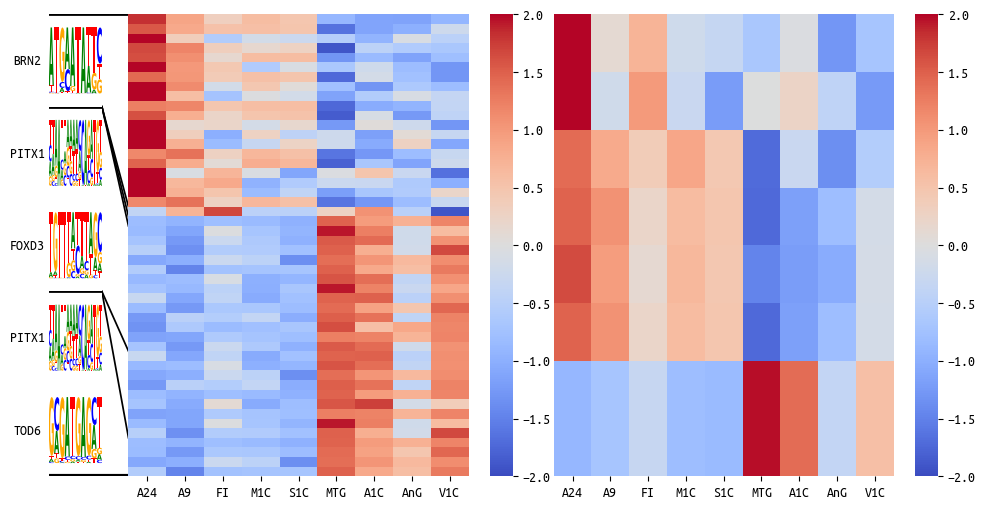

In [24]:
plt.rcParams["font.family"] = "Ubuntu Mono"
fig = plt.figure(figsize=(12, 6))
nrs = len(homer_motif_names)

gs = GridSpec(nrows=1, ncols=4, width_ratios=[1, 0.5, 8, 8])
left_column = gs[0]
left_gs = GridSpecFromSubplotSpec(nrows=nrs, ncols=1, subplot_spec=left_column)
right_column = gs[2]

group_index = [0] + left_ys_coords.tolist()
for i in range(nrs):
    curr_ax = fig.add_subplot(left_gs[i, 0])
    logomaker.Logo(homer_motif_pwms[i], ax=curr_ax, baseline_width=0.0)
    curr_ax.set_ylim(-0.2, 1.2)
    curr_ax.set_axis_off()
    curr_ax.text(-0.4, 0.5, homer_motif_names[i], va="center", ha="center", transform=curr_ax.transAxes)
    curr_bbox = curr_ax.get_position()
    if i in group_index:
        curr_ax.plot(
            [*curr_ax.get_xlim()], 
            [1.2, 1.2], 
            color="black", 
            lw=2, 
            ls="-"
        )
    if i == nrs - 1:
        curr_ax.plot(
            [*curr_ax.get_xlim()], 
            [-0.2, -0.2], 
            color="black", 
            lw=3, 
            ls="-"
        )

plot_mat = atac_counts_aggr[region_order, dar_list].X.T
plot_mat_mean = np.mean(plot_mat, axis=1, keepdims=True)
plot_mat_std = np.std(plot_mat, axis=1, keepdims=True)
plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std
right_ax = fig.add_subplot(right_column)
sns.heatmap(
    plot_mat_z,
    cmap="coolwarm",
    vmin=-2,
    vmax=2,
    ax=right_ax,
    yticklabels=[],
    xticklabels=region_order,
)

plot_mat = rna_counts_aggr[region_order, dar_target_list].X.T
plot_mat_mean = np.mean(plot_mat, axis=1, keepdims=True)
plot_mat_std = np.std(plot_mat, axis=1, keepdims=True)
plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std
rna_ax = fig.add_subplot(gs[3])
sns.heatmap(
    plot_mat_z,
    cmap="coolwarm",
    vmin=-2,
    vmax=2,
    ax=rna_ax,
    yticklabels=[],
    xticklabels=region_order,
)

middle_column = gs[1]
middle_ax = fig.add_subplot(middle_column, sharey=right_ax)
group_start = [v+1 for v in right_ys_coords]
# middle_ax.set_aspect("equal")
middle_ax.plot([0, 1], [0, 0], lw=2, color="black", ls="-")
middle_ax.plot([0, 1], [len(dar_list), len(dar_list)], lw=3, color="black", ls="-")
hspace = len(dar_list) / nrs
for i, s in enumerate(group_start):
    middle_ax.plot([0, 1], [hspace * group_index[i+1], s], lw=1.25, color="black", ls="-")
middle_ax.set_xlim(0, 1)
middle_ax.set_axis_off()

fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.savefig(figure_dir / "{}-dar-heatmap.pdf".format(subclass), dpi=300, format="pdf")

In [25]:
subclass = "PVALB"
rna_counts = sc.read_h5ad(source_dir / "{}_rna_matrix.h5ad".format(subclass))
if rna_counts.raw != None:
    rna_counts = rna_counts.raw.to_adata().copy()
rna_counts_aggr = dc.get_pseudobulk(
    rna_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=False
)
sc.pp.normalize_total(rna_counts_aggr, target_sum=1e6)
sc.pp.log1p(rna_counts_aggr, base=2)

In [26]:
subclass = "PVALB"
atac_counts = sc.read_h5ad(source_dir / "{}_atac_matrix.h5ad".format(subclass))
if atac_counts.raw != None:
    atac_counts = atac_counts.raw.to_adata().copy()
atac_counts_aggr = dc.get_pseudobulk(
    atac_counts,
    sample_col="Region",
    groups_col=None,
    min_cells=0,
    min_counts=0,
    remove_empty=False
)
sc.pp.normalize_total(atac_counts_aggr, target_sum=1e6)
sc.pp.log1p(atac_counts_aggr, base=2)

In [27]:
regional_dars = dict()
regional_dar_targets = dict()
region_order = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
for region in region_order:
    dar_table = pd.read_csv(dar_dir / subclass / "{}_result.tsv".format(region), sep="\t", header=0, index_col=0)
    dar_sig_list = dar_table[(dar_table["logFC"] > 0) & (dar_table["FDR"] < 0.01)].index.to_list()
    regional_dars[region] = dar_sig_list
    regional_dar_targets[region] = scGLUE_links_df[scGLUE_links_df["Region"].isin(dar_sig_list)]["Gene"].unique()
dar_list = [xx for region in region_order for xx in regional_dars[region]]
dar_target_list = [xx for region in region_order for xx in regional_dar_targets[region]]
right_ys_dict = {k: len(v) for k, v in regional_dars.items() if len(v) > 0}
left_ys_dict = {k: 0 for k in right_ys_dict.keys()}
homer_dict = dict()
for region_homer_dir in (homer_dir / subclass / "results").iterdir():
    region_name = region_homer_dir.name
    region_df = pd.read_csv(region_homer_dir / "knownResults.txt", sep="\t", header=0)
    region_df.reset_index(inplace=True, names=["idx"])
    region_df_sig = region_df[region_df["q-value (Benjamini)"] < 0.01].copy()
    region_df_sig.drop_duplicates("Motif Name", inplace=True)
    region_df_sig = pd.merge(region_df_sig, homer_db, left_on="Motif Name", right_on="motif_names", how="inner")
    homer_dict[region_name] = region_df_sig.head(6)
homer_motif_names = list()
homer_motif_pwms = list()
for k in right_ys_dict.keys():
    if k not in homer_dict:
        continue
    v = homer_dict[k]
    left_ys_dict[k] = len(v)
    for i, r in v.iterrows():
        index = r["idx"] + 1
        curr_pwm_df = pd.read_csv(
            homer_dir / subclass / "results" / k / "knownResults" / f"known{index}.motif",
            skiprows=1, header=None, sep="\t"
        )
        curr_pwm_df.columns = ["A", "C", "G", "T"]
        homer_motif_names.append(r["tfs"])
        homer_motif_pwms.append(curr_pwm_df)
right_ys_coords = np.cumsum([v for k, v in right_ys_dict.items()][:-1])
left_ys_coords = np.cumsum([v for k, v in left_ys_dict.items()][:-1])

In [28]:
dar_target_list = [xx for xx in dar_target_list if xx in rna_counts_aggr.var.index.to_list()]

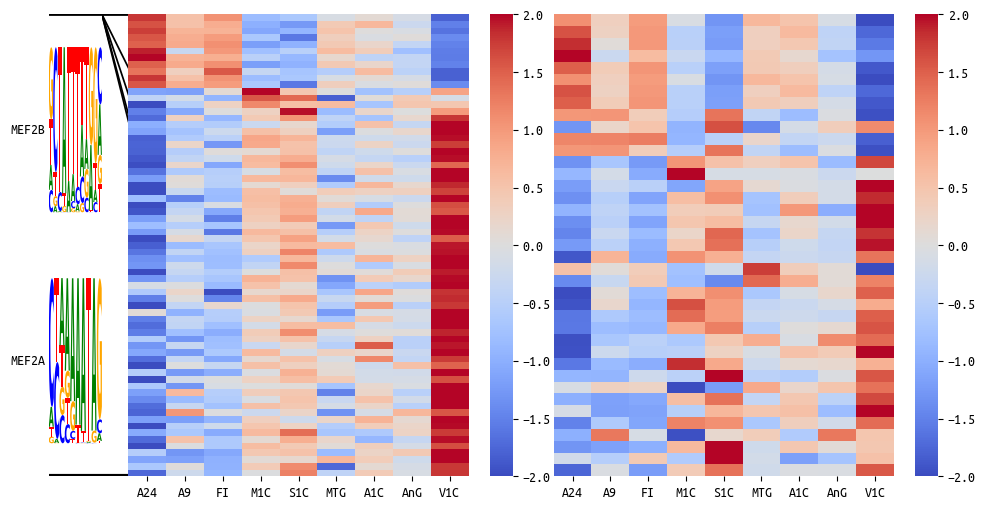

In [29]:
plt.rcParams["font.family"] = "Ubuntu Mono"
fig = plt.figure(figsize=(12, 6))
nrs = len(homer_motif_names)

gs = GridSpec(nrows=1, ncols=4, width_ratios=[1, 0.5, 8, 8])
left_column = gs[0]
left_gs = GridSpecFromSubplotSpec(nrows=nrs, ncols=1, subplot_spec=left_column)
right_column = gs[2]

group_index = [0] + left_ys_coords.tolist()
for i in range(nrs):
    curr_ax = fig.add_subplot(left_gs[i, 0])
    logomaker.Logo(homer_motif_pwms[i], ax=curr_ax, baseline_width=0.0)
    curr_ax.set_ylim(-0.2, 1.2)
    curr_ax.set_axis_off()
    curr_ax.text(-0.4, 0.5, homer_motif_names[i], va="center", ha="center", transform=curr_ax.transAxes)
    curr_bbox = curr_ax.get_position()
    if i in group_index:
        curr_ax.plot(
            [*curr_ax.get_xlim()], 
            [1.2, 1.2], 
            color="black", 
            lw=2, 
            ls="-"
        )
    if i == nrs - 1:
        curr_ax.plot(
            [*curr_ax.get_xlim()], 
            [-0.2, -0.2], 
            color="black", 
            lw=3, 
            ls="-"
        )

plot_mat = atac_counts_aggr[region_order, dar_list].X.T
plot_mat_mean = np.mean(plot_mat, axis=1, keepdims=True)
plot_mat_std = np.std(plot_mat, axis=1, keepdims=True)
plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std
right_ax = fig.add_subplot(right_column)
sns.heatmap(
    plot_mat_z,
    cmap="coolwarm",
    vmin=-2,
    vmax=2,
    ax=right_ax,
    yticklabels=[],
    xticklabels=region_order,
)

plot_mat = rna_counts_aggr[region_order, dar_target_list].X.T
plot_mat_mean = np.mean(plot_mat, axis=1, keepdims=True)
plot_mat_std = np.std(plot_mat, axis=1, keepdims=True)
plot_mat_z = (plot_mat - plot_mat_mean) / plot_mat_std
rna_ax = fig.add_subplot(gs[3])
sns.heatmap(
    plot_mat_z,
    cmap="coolwarm",
    vmin=-2,
    vmax=2,
    ax=rna_ax,
    yticklabels=[],
    xticklabels=region_order,
)

middle_column = gs[1]
middle_ax = fig.add_subplot(middle_column, sharey=right_ax)
group_start = [v+1 for v in right_ys_coords]
# middle_ax.set_aspect("equal")
middle_ax.plot([0, 1], [0, 0], lw=2, color="black", ls="-")
middle_ax.plot([0, 1], [len(dar_list), len(dar_list)], lw=3, color="black", ls="-")
hspace = len(dar_list) / nrs
for i, s in enumerate(group_start):
    middle_ax.plot([0, 1], [hspace * group_index[i+1], s], lw=1.25, color="black", ls="-")
middle_ax.set_xlim(0, 1)
middle_ax.set_axis_off()

fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.savefig(figure_dir / "{}-dar-heatmap.pdf".format(subclass), dpi=300, format="pdf")